In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

# Import relevant custom libraries
from src.eda import data_info
from src.models import AutoencoderTrainer, AnomalyDetector
from src.evaluation import ValidationEvaluation

# Import relevant libraries
import pandas as pd
import warnings
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from datetime import datetime
import re
import tensorflow as tf
import pickle
from datetime import datetime

# Config
pd.set_option('display.max_columns', None) # Ensure all columns are displayed
warnings.filterwarnings("ignore")

In [2]:
# Read relevant files
X_train = pd.read_feather("../data/processed/X_train.feather")
X_train_validate = pd.read_feather("../data/processed/X_train_validate.feather")

# Get data info
var_info = data_info(X_train)
all_cols = X_train.columns
real_cols = var_info[var_info["var_type"]=="numerical"]["var_name"].tolist()
binary_cols = var_info[var_info["var_type"]=="binary"]["var_name"].tolist()

## 1. Test the trainer

In [3]:
"""ae = AutoencoderTrainer(
    input_dim=X_train.shape[1],
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    hidden_dims=[64],
    learning_rate=0.0001,
    dropout_rate=0.2,
    lam=0.0001,
    gamma=0.25,
    verbose=True,
    max_epochs=500,
    plot_losses=True,
    dp_sgd=True,
    target_epsilon=3,
    delta=1e-5,
    batch_size=256,
    l2norm_pct=90,
    patience_limit=20,
    c2=1.5
)
autoencoder = ae.train(X_train, X_train_validate)"""

'ae = AutoencoderTrainer(\n    input_dim=X_train.shape[1],\n    real_cols=real_cols,\n    binary_cols=binary_cols,\n    all_cols=all_cols,\n    hidden_dims=[64],\n    learning_rate=0.0001,\n    dropout_rate=0.2,\n    lam=0.0001,\n    gamma=0.25,\n    verbose=True,\n    max_epochs=500,\n    plot_losses=True,\n    dp_sgd=True,\n    target_epsilon=3,\n    delta=1e-5,\n    batch_size=256,\n    l2norm_pct=90,\n    patience_limit=20,\n    c2=1.5\n)\nautoencoder = ae.train(X_train, X_train_validate)'

## 2. Test the anomaly detector

In [4]:
"""# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# After training
detector = AnomalyDetector(
    model=autoencoder,
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    lam=ae.lam,
)

# Compute scores
scores = detector._compute_anomaly_scores(X_validate)

# Detect
threshold = np.quantile(scores, 0.8)
y_pred = detector._detect(scores, threshold)

# Evaluate
metrics = detector._evaluate(y_pred, y_validate, scores)
print(metrics)"""

'# Read relevant files\nX_validate = pd.read_feather("../data/processed/X_validate.feather")\ny_validate = pd.read_feather("../data/processed/y_validate.feather")\n\n# After training\ndetector = AnomalyDetector(\n    model=autoencoder,\n    real_cols=real_cols,\n    binary_cols=binary_cols,\n    all_cols=all_cols,\n    lam=ae.lam,\n)\n\n# Compute scores\nscores = detector._compute_anomaly_scores(X_validate)\n\n# Detect\nthreshold = np.quantile(scores, 0.8)\ny_pred = detector._detect(scores, threshold)\n\n# Evaluate\nmetrics = detector._evaluate(y_pred, y_validate, scores)\nprint(metrics)'

## 3. Hyperparameter Tuning

### 3.1. Tuning Implementation

In [5]:
# Epsilon = 1
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=50 --epsilon 1 --delta 1e-5
# Epsilon = 3
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=30 --epsilon 3 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=40 --epsilon 3 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=40 --epsilon 3 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=50 --epsilon 3 --delta 1e-5
# Epsilon = 5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=30 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=30 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=30 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=30 --epsilon 5 --delta 1e-5

### 3.2. Inspect Convergence of Bayesian Optimization

In [6]:
"""metric = "f1_score"
version = 202504152141
results_df = pd.read_csv(f"../experiments/hyperparam_tune/dpsgd/bayes_{metric}_{version}.csv")"""

'metric = "f1_score"\nversion = 202504152141\nresults_df = pd.read_csv(f"../experiments/hyperparam_tune/dpsgd/bayes_{metric}_{version}.csv")'

In [7]:
"""# Compute cumulative best AUC (i.e., convergence plot)
results_df["best_so_far"] = results_df[metric].cummax()

# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(results_df.index, results_df["best_so_far"], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Validation {}".format(metric.title().replace("_", " ")))
plt.grid(True)
plt.tight_layout()
plt.show()"""

'# Compute cumulative best AUC (i.e., convergence plot)\nresults_df["best_so_far"] = results_df[metric].cummax()\n\n# Plot convergence\nplt.figure(figsize=(10, 5))\nplt.plot(results_df.index, results_df["best_so_far"], marker=\'o\')\nplt.xlabel("Iteration")\nplt.ylabel("Validation {}".format(metric.title().replace("_", " ")))\nplt.grid(True)\nplt.tight_layout()\nplt.show()'

### 3.3. Compare Models Based on Validation Set

In [8]:
# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# Initialize the validation evaluation
valeval = ValidationEvaluation(X_validate, y_validate, real_cols, binary_cols, all_cols, dp_sgd=True)
    
# Read the log file
log_path = "../logs/dpsgd_tune_log.txt"

# Extract the latest successful Bayesian versions
latest_successful_versions = valeval.extract_latest_successful_bayesian_versions(log_path)
print(latest_successful_versions)

# Evaluate the model performance
eval_results = valeval.evaluate_model_performance(latest_successful_versions)
display(eval_results)

{'202504180153': ('AUC', '1', '1e-5'), '202504171527': ('AUC', '3', '1e-5'), '202504171601': ('AUC', '5', '1e-5'), '202504171636': ('Precision', '1', '1e-5'), '202504171658': ('Precision', '3', '1e-5'), '202504171731': ('Precision', '5', '1e-5'), '202504171746': ('F1 Score', '1', '1e-5'), '202504171754': ('F1 Score', '3', '1e-5'), '202504171805': ('F1 Score', '5', '1e-5'), '202504171816': ('Recall', '1', '1e-5'), '202504171828': ('Recall', '3', '1e-5'), '202504171842': ('Recall', '5', '1e-5')}
Evaluating version 202504180153
Evaluating version 202504171527
Evaluating version 202504171601
Evaluating version 202504171636
Evaluating version 202504171658
Evaluating version 202504171731
Evaluating version 202504171746
Evaluating version 202504171754
Evaluating version 202504171805
Evaluating version 202504171816
Evaluating version 202504171828
Evaluating version 202504171842


,accuracy,precision,recall,f1_score,auc,hidden_dims,batch_size,dropout_rate,learning_rate,lam,gamma,l2norm_pct,threshold,tuned_by,epsilon,delta
version,,,,,,,,,,,,,,,,
202504180153,0.722091,0.338479,0.399566,0.366494,0.647589,"(64, 32)",64.0,0.000000e+00,0.000050,0.062071,0.500000,95.0,22.700356,AUC,1,1e-5
202504171527,0.731169,0.357589,0.422126,0.387187,0.652951,"(64,)",64.0,4.849369e-18,0.000300,0.000100,0.350000,95.0,12.607061,AUC,3,1e-5
202504171601,0.779174,0.443890,0.386117,0.412993,0.676011,"(64,)",64.0,0.000000e+00,0.000500,0.000100,0.350000,95.0,7.842445,AUC,5,1e-5
202504171636,0.792092,0.432810,0.107592,0.172342,0.562813,"(64, 32)",64.0,0.000000e+00,0.000136,0.000100,0.221294,86.0,28.820192,Precision,1,1e-5
202504171658,0.817753,0.689354,0.171367,0.274496,0.627273,"(64, 32)",64.0,1.608004e-01,0.000300,0.000100,0.350000,80.0,17.081095,Precision,3,1e-5
202504171731,0.823339,0.745201,0.185249,0.296734,0.657551,"(64, 32)",64.0,9.993748e-02,0.000500,0.000100,0.350000,95.0,16.868478,Precision,5,1e-5
202504171746,0.682465,0.306081,0.456399,0.366423,0.637037,"(64, 32)",64.0,0.000000e+00,0.000050,0.000100,0.350000,95.0,13.646754,F1 Score,1,1e-5
202504171754,0.738500,0.373025,0.440347,0.403900,0.664752,"(64,)",67.0,2.000000e-01,0.000300,0.000100,0.350000,94.0,10.512618,F1 Score,3,1e-5
202504171805,0.740944,0.378170,0.446421,0.409471,0.674292,"(64,)",70.0,2.000000e-01,0.000500,0.000100,0.350000,80.0,6.757477,F1 Score,5,1e-5


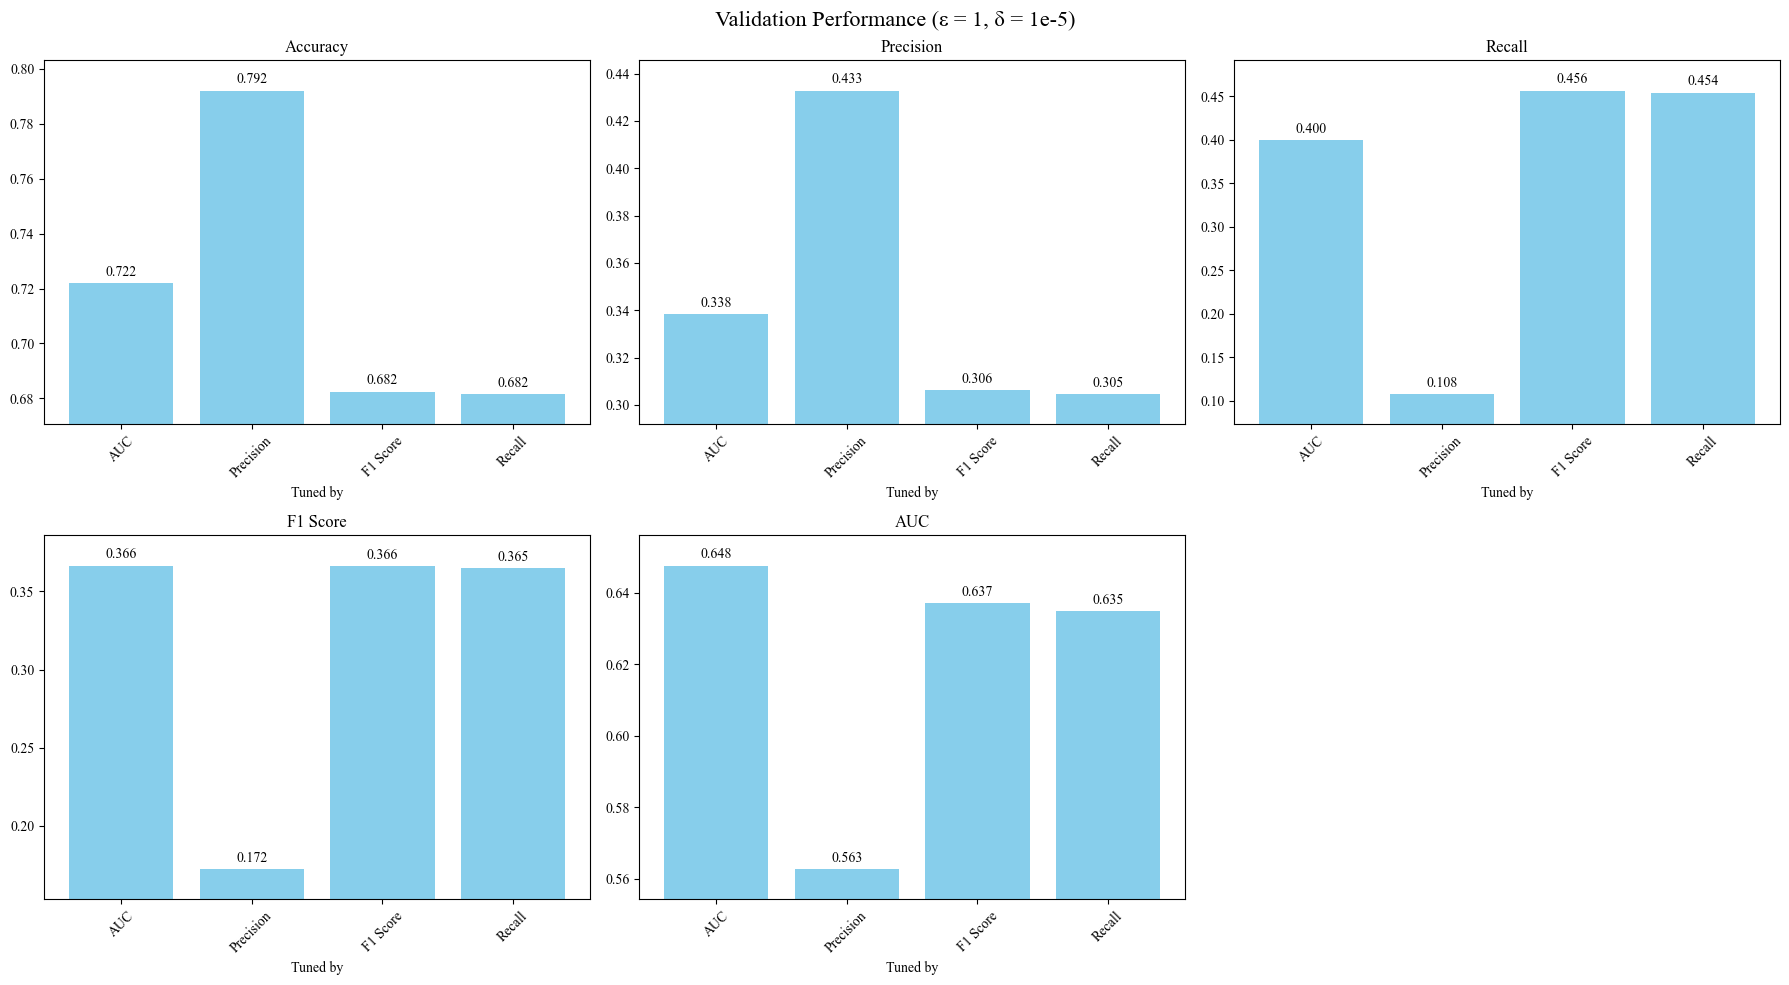

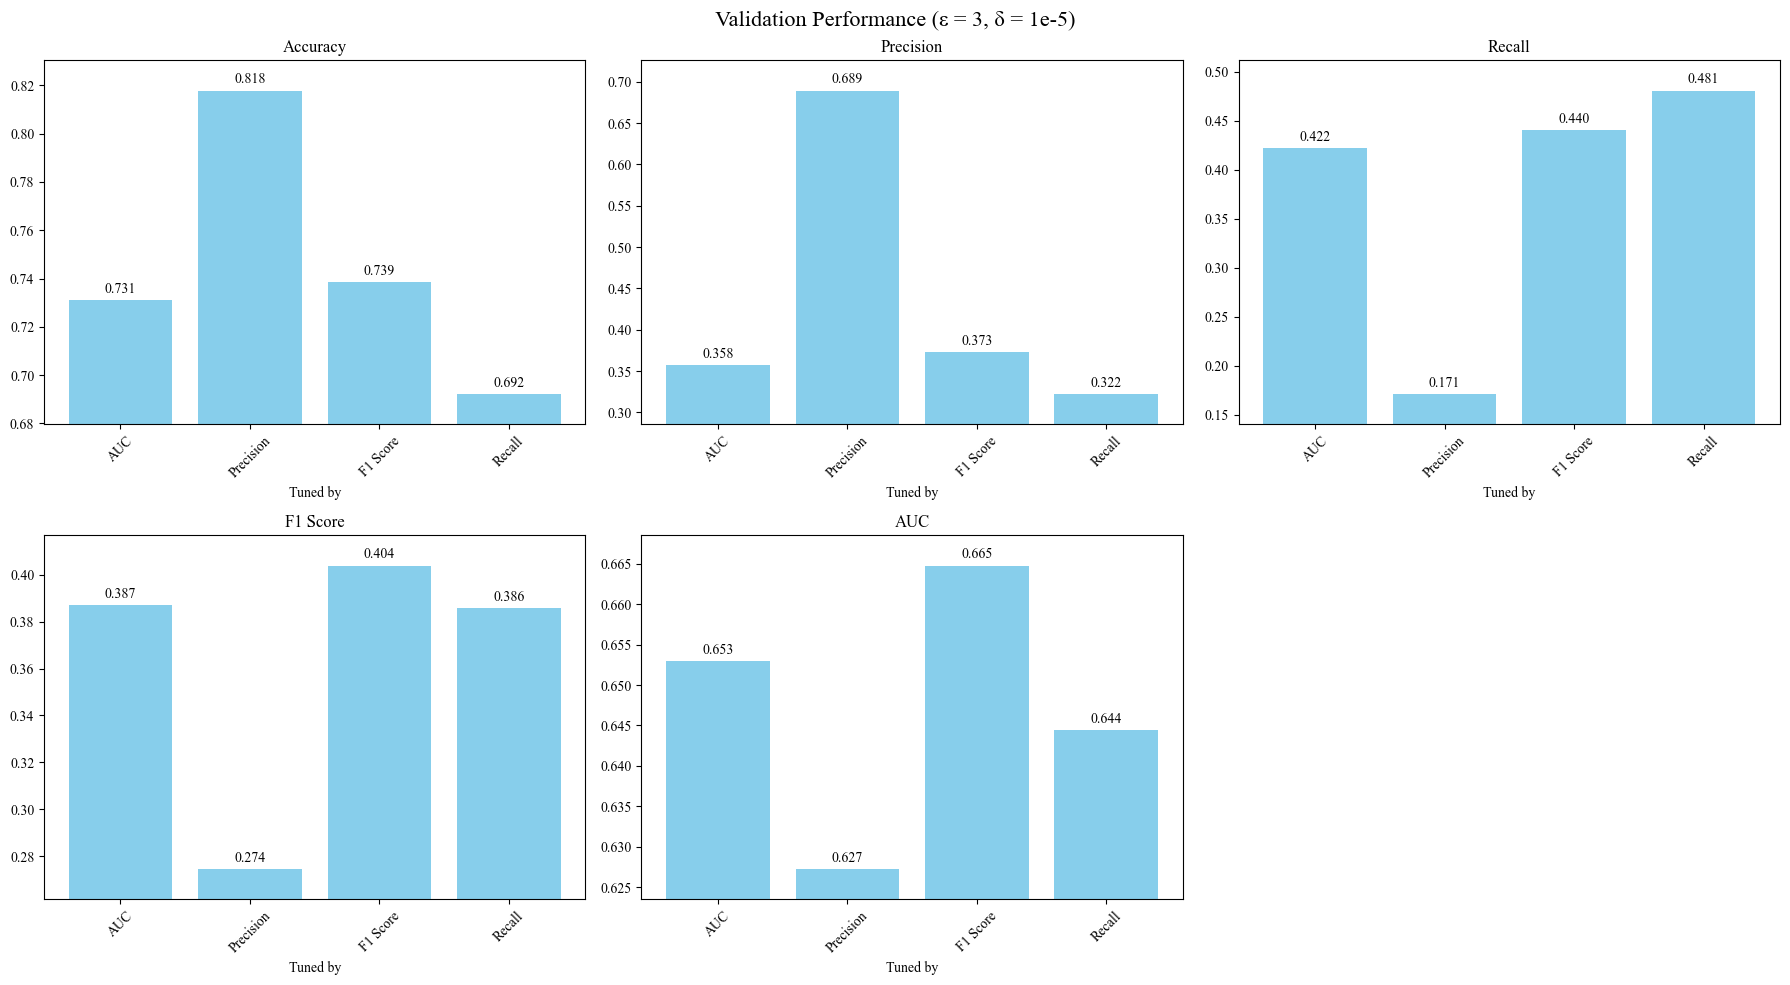

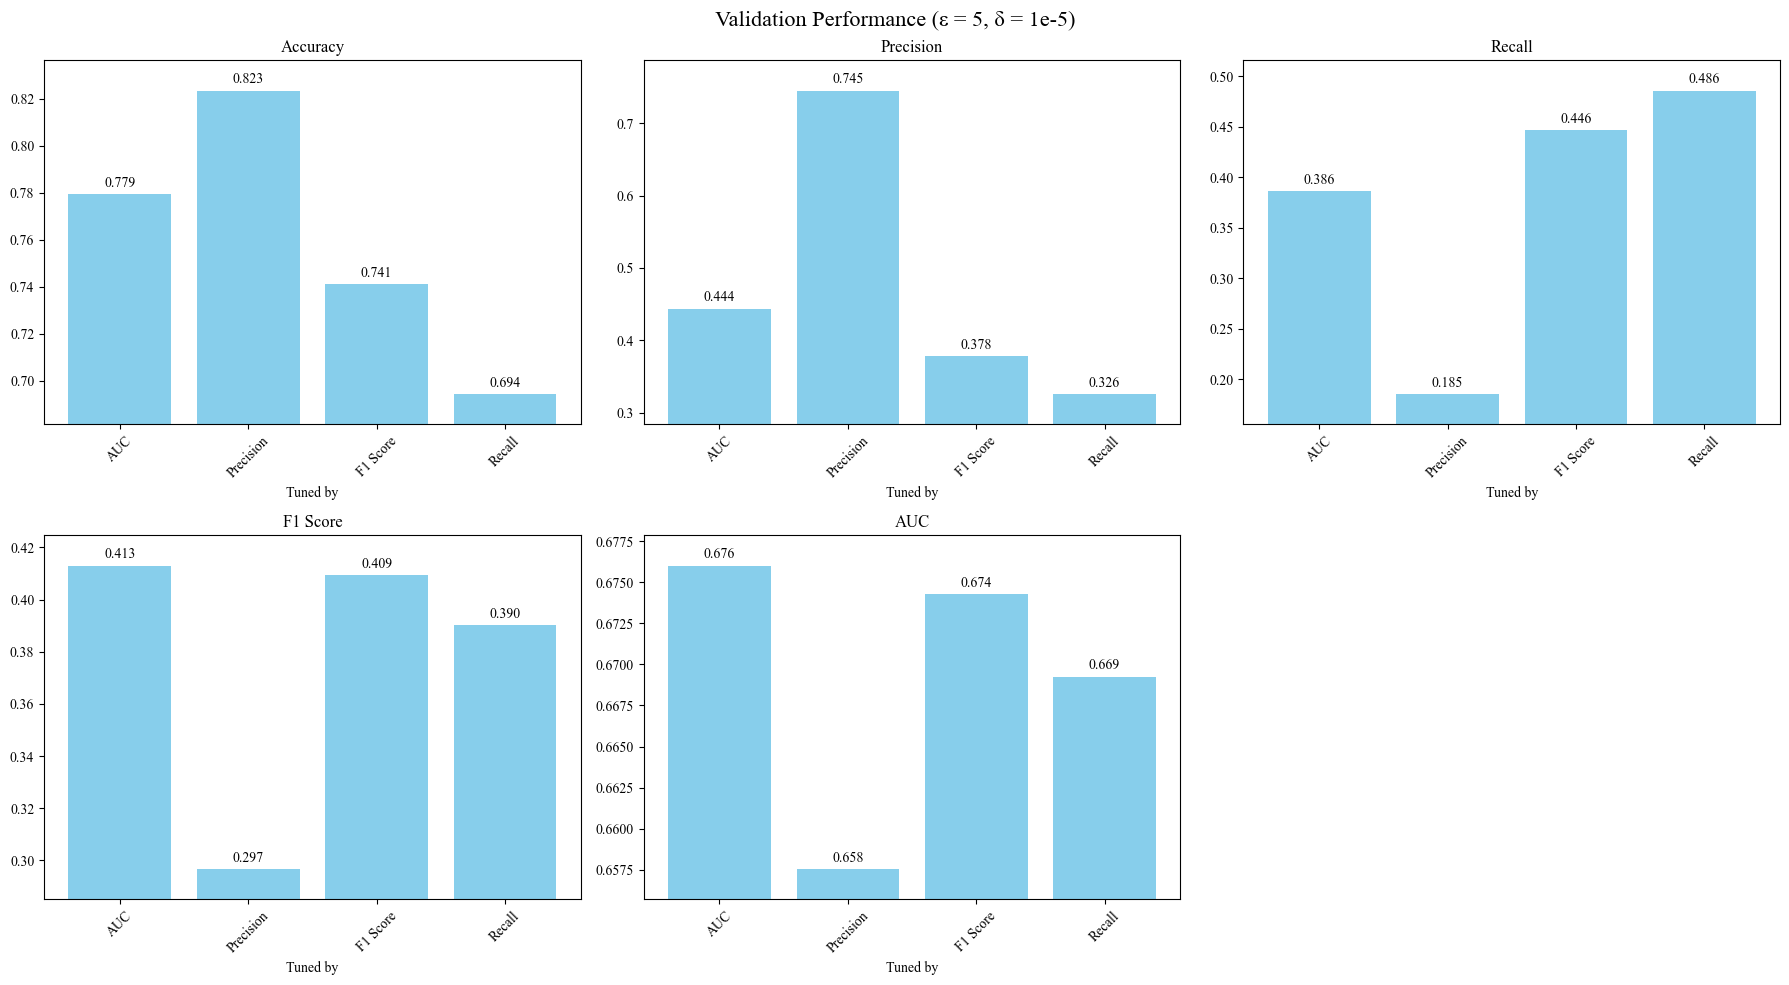

In [9]:
##################################################
## Plot a barplot of the validation performance ##
##################################################

valeval.plot_bar(eval_results, save=False)

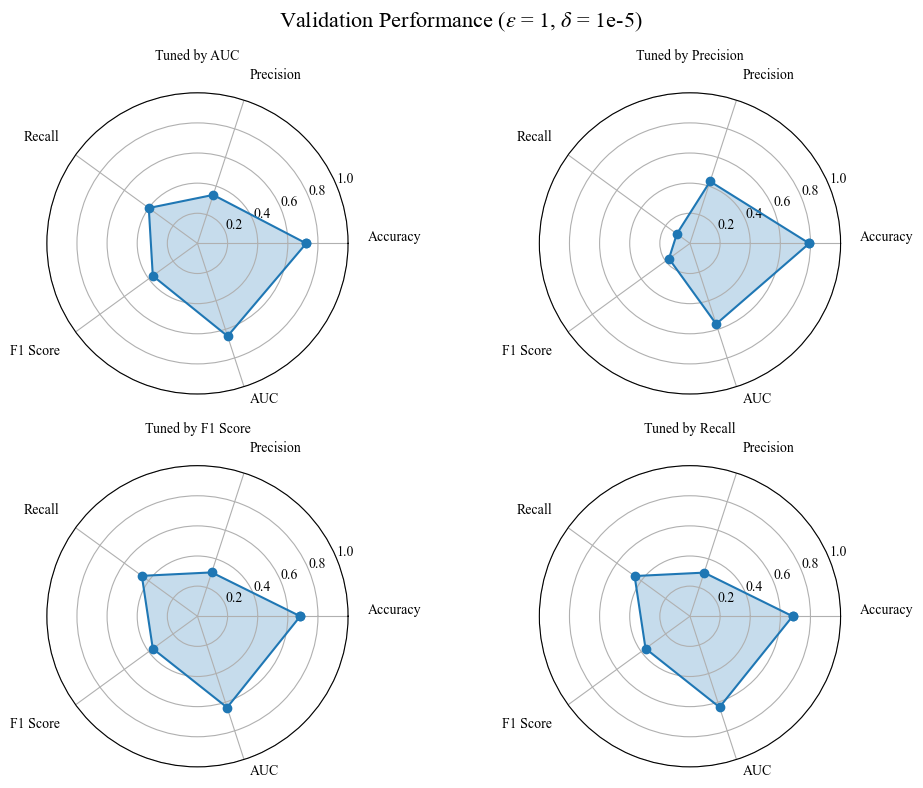

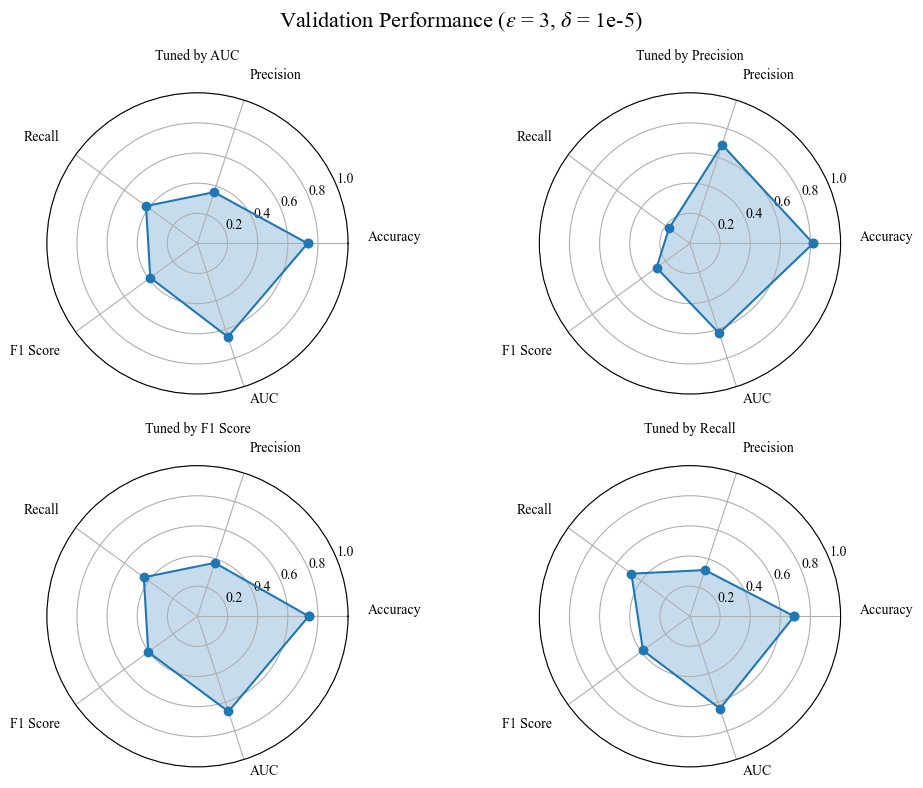

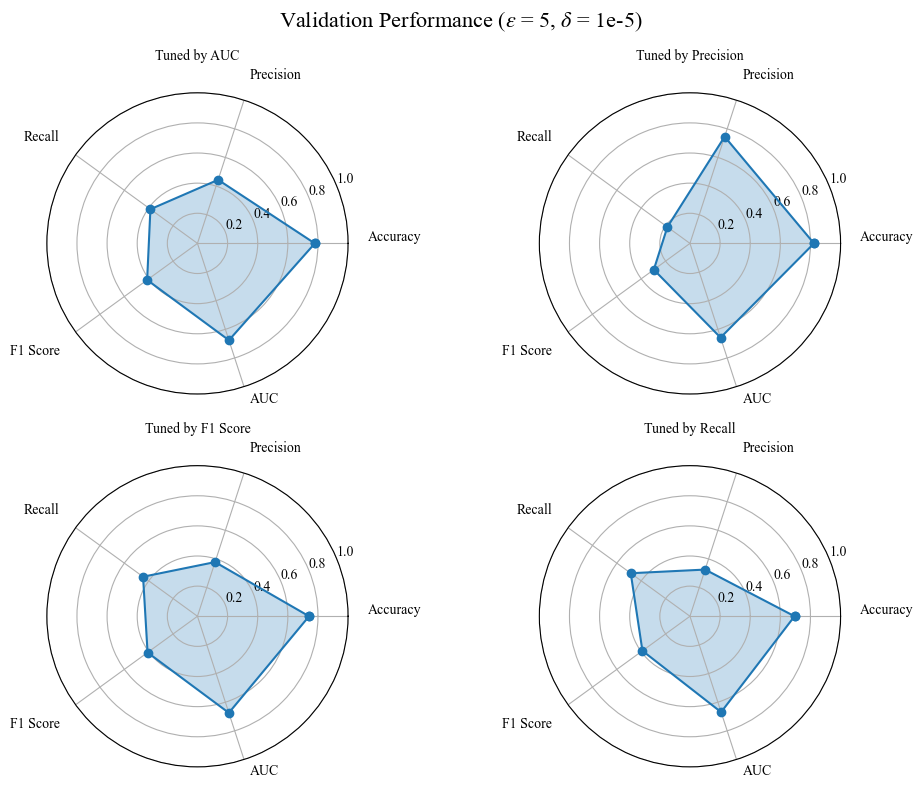

In [10]:
#####################################################
## Plot a radar plot of the validation performance ##
#####################################################
 
valeval.plot_radar(eval_results)

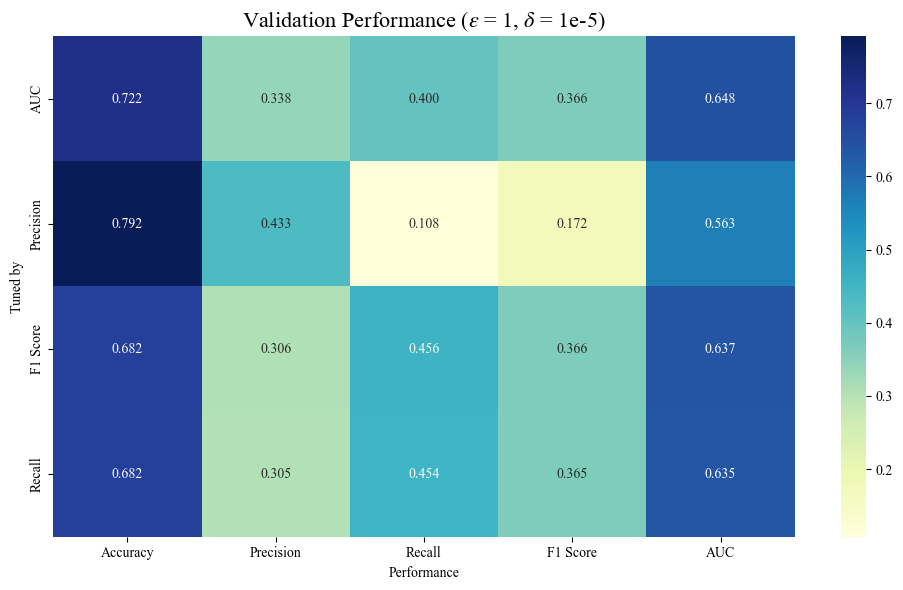

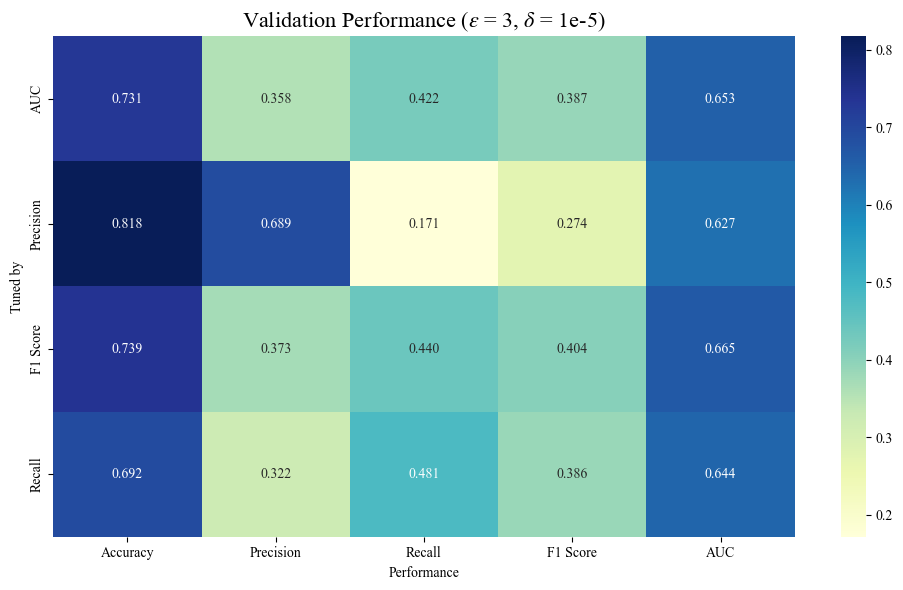

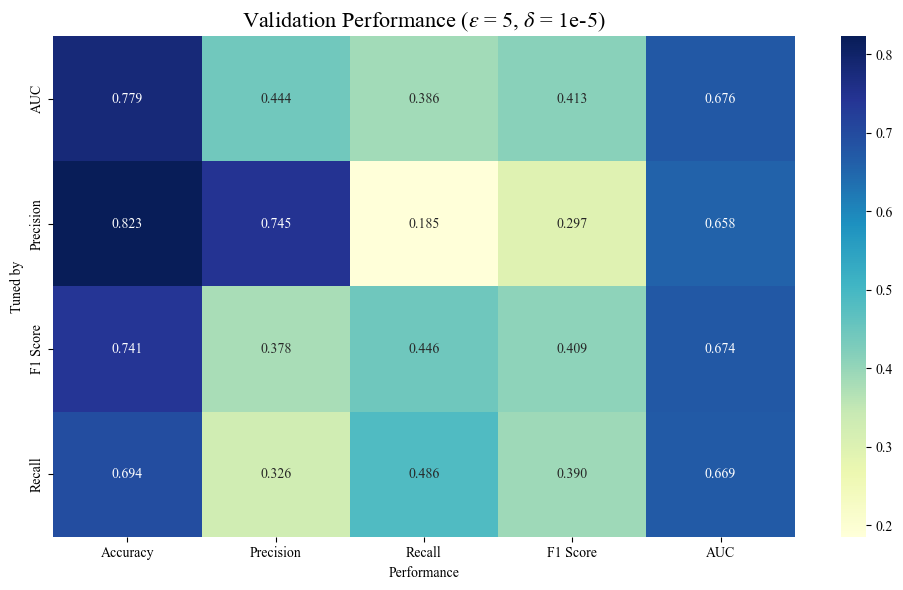

In [11]:
##################################################
## Plot a heatmap of the validation performance ##
##################################################
 
valeval.plot_heatmap(eval_results)

In [12]:
from src.dp_utils import DPSGDSanitizer

dp = DPSGDSanitizer(12791, 150, 1, 500, 1e-5)
dp.compute_noise_from_eps()

9.830506518390466

In [13]:
import os

def build_directory_tree(root_dir):
    tree = {"_files": []}  # special key for files in the current folder
    for entry in os.listdir(root_dir):
        full_path = os.path.join(root_dir, entry)
        if os.path.isdir(full_path):
            tree[entry] = build_directory_tree(full_path)  # recursive call for subfolder
        else:
            tree["_files"].append(entry)  # add file to current folder
    return tree

# experiments folder
folder_path = '../experiments'
directory_tree = build_directory_tree(folder_path)
print("experiments folder:", directory_tree)

# results folder
folder_path = '../results'
directory_tree = build_directory_tree(folder_path)
print("results folder:", directory_tree)

experiments folder: {'_files': [], 'privacy_account': {'_files': ['202504171658_noise3.6840.csv', '202504171746_noise9.8077.csv', '202504171754_noise3.7663.csv', '202504171828_noise4.5524.csv', '202504180153_noise9.8077.csv', '202504171731_noise2.4180.csv', '202504171500_noise10.1081.csv', '202504171601_noise2.4180.csv', '202504171527_noise3.6840.csv', '202504171842_noise2.9063.csv', '202504171816_noise9.8077.csv', '202504171805_noise2.5200.csv', '202504171636_noise9.8077.csv']}, 'hyperparam_tune': {'_files': [], 'baseline': {'_files': ['bayes_auc_202504131912.csv', 'bayes_precision_202504130111.csv', 'bayes_recall_202504131715.csv', 'bayes_f1_score_202504130119.csv', 'bayes_auc_202504131714.csv', 'bayes_auc_202504130054.csv', 'bayes_auc_202504130052.csv']}, 'dpsgd': {'_files': ['bayes_recall_202504171816.csv', 'bayes_recall_202504171828.csv', 'bayes_precision_202504171658.csv', 'bayes_auc_202504171601.csv', 'bayes_f1_score_202504171746.csv', 'bayes_f1_score_202504171805.csv', 'bayes_a